In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [64]:
import tensorflow as tf

print(tf.__version__)

def tf_reset():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    return tf.Session()

1.15.0


In [65]:
from google.colab import files
uploaded = files.upload()

Saving data-03-diabetes.csv to data-03-diabetes (1).csv


In [66]:
dataset = pd.read_csv("data-03-diabetes.csv", header = None)
X = dataset.iloc[ : , 0:8].values
Y = dataset.iloc[ :, 8:9].values
print(X.shape)
print(Y.shape)

(759, 8)
(759, 1)


In [67]:
# the contents of the dataframe
dataset

,0,1,2,3,4,5,6,7,8
0,-0.294118,0.487437,0.180328,-0.292929,0.000000,0.001490,-0.531170,-0.033333,0
1,-0.882353,-0.145729,0.081967,-0.414141,0.000000,-0.207153,-0.766866,-0.666667,1
2,-0.058824,0.839196,0.049180,0.000000,0.000000,-0.305514,-0.492741,-0.633333,0
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,0.000000,1
4,0.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000,0
...,...,...,...,...,...,...,...,...,...
754,0.176471,0.015075,0.245902,-0.030303,-0.574468,-0.019374,-0.920581,0.400000,1
755,-0.764706,0.226131,0.147541,-0.454545,0.000000,0.096870,-0.776260,-0.800000,1
756,-0.411765,0.216080,0.180328,-0.535354,-0.735225,-0.219076,-0.857387,-0.700000,1
757,-0.882353,0.266332,-0.016393,0.000000,0.000000,-0.102832,-0.768574,-0.133333,0


**All the variables are numerical. No need of encoding.**

In [68]:
# summary statistics
dataset.describe()

,0,1,2,3,4,5,6,7,8
count,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000
mean,-0.407657,0.218563,0.176505,-0.289735,-0.323534,-0.032245,-0.663253,-0.516162,0.653491
std,0.386260,0.306419,0.201287,0.258480,0.375544,0.205376,0.283056,0.400794,0.476171
min,-0.882353,-0.557789,-0.606557,-0.858586,-0.966903,-0.457526,-0.994876,-0.966667,0.000000
25%,-0.764706,-0.005025,0.016393,-0.494949,-0.716312,-0.178837,-0.858241,-0.866667,0.000000
50%,-0.529412,0.165829,0.180328,-0.292929,0.000000,-0.034277,-0.747225,-0.633333,1.000000
75%,0.000000,0.407035,0.311475,0.000000,0.000000,0.087928,-0.531597,-0.233333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**No need to normalize the data. All data values ranges from -1 to 1.**

In [69]:
# total count of the non-empty cells for each attribute 
dataset.count()

0    759
1    759
2    759
3    759
4    759
5    759
6    759
7    759
8    759
dtype: int64

**There are no missing values.**

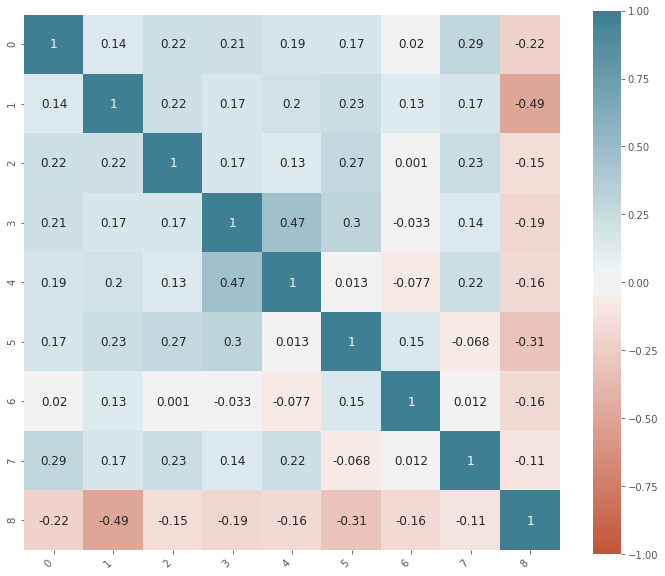

In [70]:
# correlation map
corr = dataset.corr()
ax = plt.subplots( figsize =( 12 , 10 ) )
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True, 
    annot_kws = { 'fontsize' : 12 }
 
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

**There is no strong positive or negative correlation between any two attributes.**

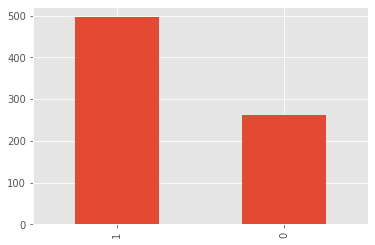

In [71]:
dataset[8].value_counts().plot(kind='bar')

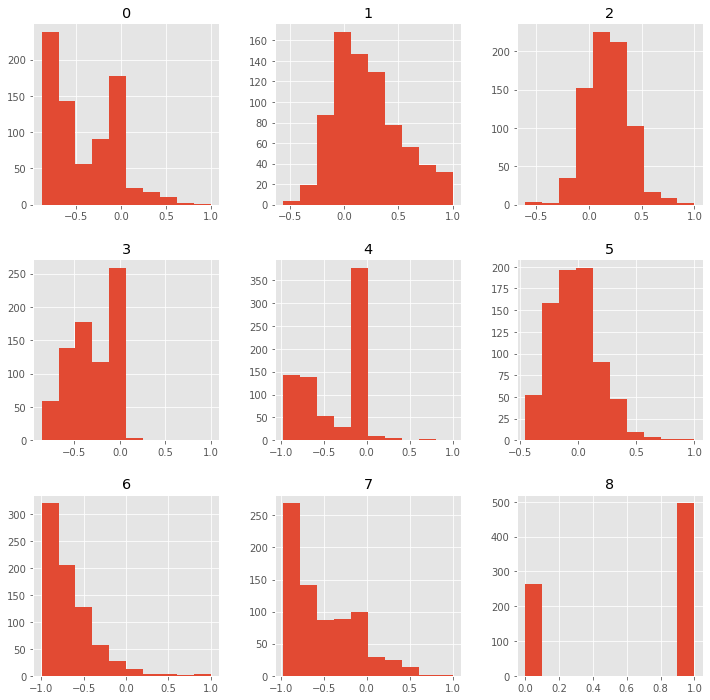

In [72]:
dataset.hist(figsize=(12,12));

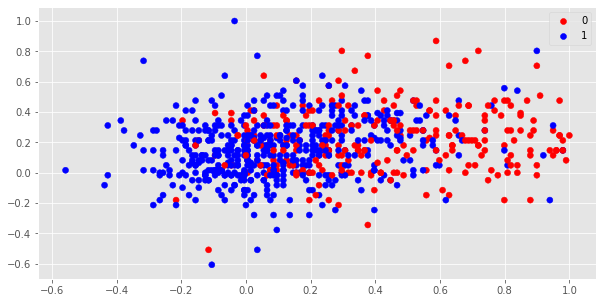

In [73]:
from matplotlib.colors import ListedColormap
colours = ListedColormap(['r','b'])
classes = ['0', '1']
plt.figure(figsize=(10,5))
scatter = plt.scatter(dataset[1], dataset[2], c = dataset[8], cmap = colours)
plt.legend(handles=scatter.legend_elements()[0],labels=classes)
plt.show()

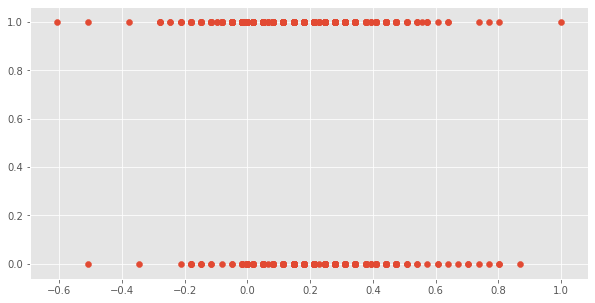

In [74]:
plt.figure(figsize=(10,5))
plt.scatter(dataset[2], dataset[8])

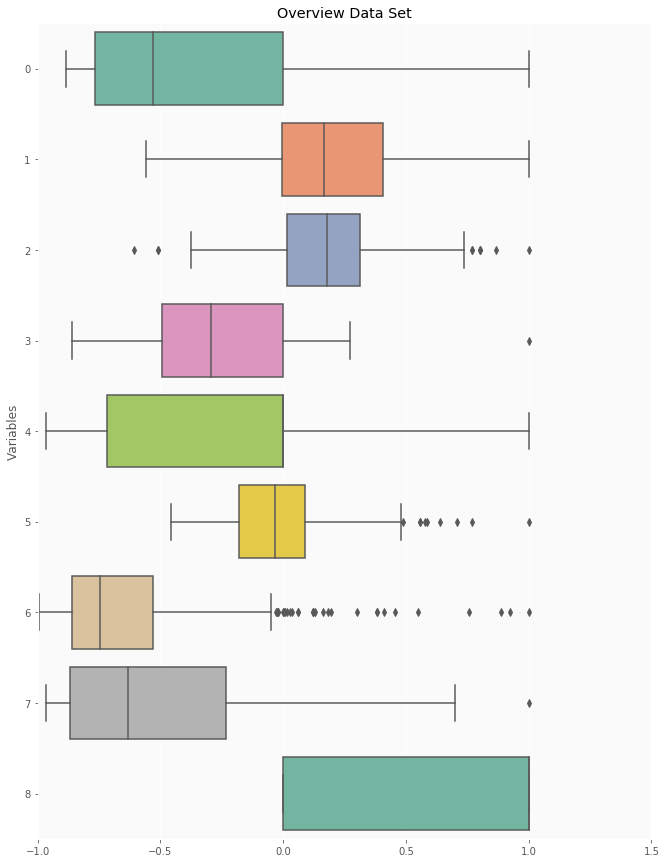

In [75]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-1, 1.5))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = dataset, 
  orient = 'h', 
  palette = 'Set2')

In [76]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(607, 8)
(607, 1)
(152, 8)
(152, 1)


In [0]:
# Helper class to perform K-Folds Validation splitting
class CrossValidationFolds(object):
    
    def __init__(self, data, labels, num_folds, shuffle=True):
        self.data = data
        self.labels = labels
        self.num_folds = num_folds
        self.current_fold = 0
        
        # Shuffle Dataset
        if shuffle:
            perm = np.random.permutation(self.data.shape[0])
            data = data[perm]
            labels = labels[perm]
    
    def split(self):
        current = self.current_fold
        size = int(self.data.shape[0]/self.num_folds)
        
        index = np.arange(self.data.shape[0])
        lower_bound = index >= current*size
        upper_bound = index < (current + 1)*size
        cv_region = lower_bound*upper_bound

        cv_data = self.data[cv_region]
        train_data = self.data[~cv_region]
        
        cv_labels = self.labels[cv_region]
        train_labels = self.labels[~cv_region]
        
        self.current_fold += 1
        return (train_data, train_labels), (cv_data, cv_labels)

In [78]:
sess = tf_reset()

accuracy_log = []
FOLDS = 5
data = CrossValidationFolds(X_train, y_train, FOLDS)

def create_model():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 8])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])

    # create variables
    W0 = tf.get_variable(name='W0', shape=[8, 32], initializer=tf.contrib.layers.xavier_initializer())
    W1 = tf.get_variable(name='W1', shape=[32, 32], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable(name='W2', shape=[32, 1], initializer=tf.contrib.layers.xavier_initializer())

    b0 = tf.get_variable(name='b0', shape=[32], initializer=tf.constant_initializer(0.))
    b1 = tf.get_variable(name='b1', shape=[32], initializer=tf.constant_initializer(0.))
    b2 = tf.get_variable(name='b2', shape=[1], initializer=tf.constant_initializer(0.))

    weights = [W0, W1, W2]
    bias = [b0, b1, b2]
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.sigmoid]
    
    # create computation graph
    layer = input_ph

    for w, b, activation in zip(weights, bias, activations):
      layer = tf.matmul(layer, w) + b
      if activation is not None:
        layer = activation(layer)
    output_pred = layer
    
    return input_ph, output_ph, output_pred
    
input_ph, output_ph, output_pred = create_model()
    
# create loss
mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph))

# create optimizer
opt = tf.train.GradientDescentOptimizer(0.01).minimize(mse)

# initialize variables
sess.run(tf.global_variables_initializer())

# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 50

for i in range(FOLDS):
  print('\nCurrent fold: {}\n'.format(data.current_fold + 1))
  (train_input, train_target), (cv_input, cv_target) = data.split()

  for training_step in range(10000):
    
    # run the optimizer and get the mse
    _, mse_run = sess.run([opt, mse], feed_dict={input_ph: train_input, output_ph: train_target})
    
    # print the mse every so often
    if training_step % 1000 == 0:
        print('{0:04d} mse: {1:.3f}'.format(training_step, mse_run))

 # print the accuracy on validation data
  y_pred =sess.run(output_pred,feed_dict={input_ph:cv_input})
  y_pred = (y_pred > 0.5)
  ac = accuracy_score(cv_target, y_pred)
  print('Training MSE: {0: .2f} '.format(mse_run))
  print('Validation accuracy: {0: .2f} '.format(ac))
  accuracy_log.append(ac)

saver.save(sess, '/tmp/model.ckpt')

# average accuracy on validation datasets
final_accuracy = np.array(accuracy_log).mean()
print('Final validation score, Accuracy : {0: .2f} '.format(final_accuracy))




Current fold: 1

0000 mse: 0.128
1000 mse: 0.106
2000 mse: 0.101
3000 mse: 0.096
4000 mse: 0.091
5000 mse: 0.087
6000 mse: 0.084
7000 mse: 0.082
8000 mse: 0.080
9000 mse: 0.079
Training MSE:  0.08 
Validation accuracy:  0.73 

Current fold: 2

0000 mse: 0.082
1000 mse: 0.081
2000 mse: 0.081
3000 mse: 0.080
4000 mse: 0.080
5000 mse: 0.080
6000 mse: 0.079
7000 mse: 0.079
8000 mse: 0.079
9000 mse: 0.079
Training MSE:  0.08 
Validation accuracy:  0.80 

Current fold: 3

0000 mse: 0.081
1000 mse: 0.080
2000 mse: 0.079
3000 mse: 0.079
4000 mse: 0.079
5000 mse: 0.079
6000 mse: 0.078
7000 mse: 0.078
8000 mse: 0.078
9000 mse: 0.078
Training MSE:  0.08 
Validation accuracy:  0.82 

Current fold: 4

0000 mse: 0.073
1000 mse: 0.072
2000 mse: 0.072
3000 mse: 0.072
4000 mse: 0.071
5000 mse: 0.071
6000 mse: 0.071
7000 mse: 0.071
8000 mse: 0.071
9000 mse: 0.071
Training MSE:  0.07 
Validation accuracy:  0.69 

Current fold: 5

0000 mse: 0.073
1000 mse: 0.072
2000 mse: 0.072
3000 mse: 0.071
4000 mse: 

In [80]:
# predict the output for test data
saver.restore(sess,'/tmp/model.ckpt')
y_pred =sess.run(output_pred,feed_dict={input_ph:X_test})
y_pred = (y_pred > 0.5)
print(y_pred)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
[[False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ Tru

In [81]:
# accuracy of the model on the test data 
accuracy_score(y_test, y_pred)

0.8092105263157895